In [ ]:
import os
import random
from collections import Counter
from zipfile import ZipFile
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [ ]:
import torchvision
import torchvision.transforms as T

In [ ]:
import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [ ]:
captions = pd.read_csv('./captions.txt')
captions.shape

(40455, 2)

In [ ]:
with ZipFile('./images800.zip') as z:
  z.extractall()

In [ ]:
!ls ./images800/ | wc -l

803


In [ ]:
!cd ./images800/ && ls *.jpg | head -n 5

101654506_8eb26cfb60.jpg
101669240_b2d3e7f17b.jpg
102351840_323e3de834.jpg
102455176_5f8ead62d5.jpg
103106960_e8a41d64f8.jpg


In [ ]:
captions.head(3)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .


In [ ]:
# Each image has 5 captions.
img_name = '103106960_e8a41d64f8.jpg'
captions.loc[captions['image'] == img_name, 'caption'].tolist()

['A boy with a stick kneeling in front of a goalie net',
 'A child in a red jacket playing street hockey guarding a goal .',
 'A young kid playing the goalie in a hockey rink .',
 'A young male kneeling in front of a hockey goal with a hockey stick in his right hand .',
 'Hockey goalie boy in red jacket crouches by goal , with stick .']

In [ ]:
random.choice(captions.loc[captions['image'] == img_name, 'caption'].tolist())

'Hockey goalie boy in red jacket crouches by goal , with stick .'

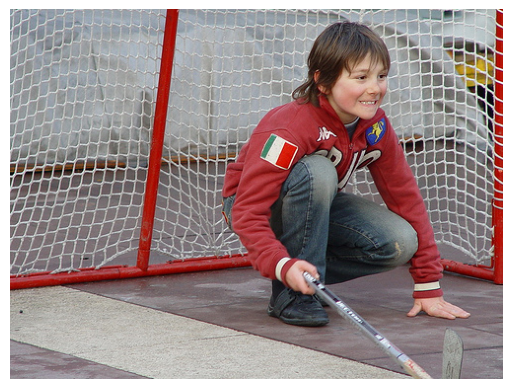

In [ ]:
path_images = Path('./images800')

img = Image.open(path_images / img_name)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
tokenizer = get_tokenizer('basic_english')

In [ ]:
tokenizer('Hockey goalie boy in red jacket crouches by goal , with stick .')

['hockey',
 'goalie',
 'boy',
 'in',
 'red',
 'jacket',
 'crouches',
 'by',
 'goal',
 ',',
 'with',
 'stick',
 '.']

In [ ]:
counter = Counter()
Counter(tokenizer('A boy with a stick kneeling in front of a goalie net'))

Counter({'a': 3,
         'boy': 1,
         'with': 1,
         'stick': 1,
         'kneeling': 1,
         'in': 1,
         'front': 1,
         'of': 1,
         'goalie': 1,
         'net': 1})

In [ ]:
# Let's build the vocabulary, using the captions.

counter = Counter() # initialize the counter
for line in captions['caption'].values:
  counter.update(tokenizer(line))

vocab = build_vocab_from_iterator([counter], min_freq= 5)


In [ ]:
len(vocab.get_itos())

3001

In [ ]:
idx = vocab['boy']
idx, vocab.get_itos()[idx]

(14, 'boy')

In [ ]:
# Indexing is NOT necessarily alphabetically.
vocab['boy'], vocab['red'], vocab['jacket']

(14, 24, 95)

In [ ]:
unk_token = '<unk>'
pad_token = '<pad>'
sos_token = '<sos>'
eos_token = '<eos>'

vocab.insert_token(unk_token, 0)
vocab.insert_token(pad_token, 1)
vocab.insert_token(sos_token, 2)
vocab.insert_token(eos_token, 3)

In [ ]:
vocab['<unk>']

0

In [ ]:
data1 = {
    'image': ['a.jpg', 'a.jpg', 'b.jpg'],
    'caption': ['a kid is thinking', 'a kid is reading a book', 'two people drinking tea']
}
df1 = pd.DataFrame(data1)
dict1 = df1.groupby('image')['caption'].apply(list).to_dict()
dict1

{'a.jpg': ['a kid is thinking', 'a kid is reading a book'],
 'b.jpg': ['two people drinking tea']}

In [ ]:
len(dict1)

2

In [ ]:
dict1.keys()

dict_keys(['a.jpg', 'b.jpg'])

In [ ]:
dict1['a.jpg']

['a kid is thinking', 'a kid is reading a book']

In [ ]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, vocab, tokenizer, transform=None):
        self.root_dir = Path(root_dir)
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.transform = transform

        df_captions = pd.read_csv(captions_file)
        self.img_names = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
        df_captions = df_captions.loc[df_captions['image'].isin(self.img_names)]
        self.dict_captions = df_captions.groupby('image')['caption'].apply(list).to_dict()

    def __len__(self):
        return len(self.img_names)  # Assumes all images have captions.

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        print('******** ', img_name)
        caption = random.choice(self.dict_captions[img_name])

        img = Image.open(self.root_dir / img_name).convert('RGB')

        if self.transform:
            img = self.transform(img)

        caption_vec = self._get_caption_idx(caption)

        return img, torch.tensor(caption_vec)

    def _get_caption_idx(self, caption):
        return [self.vocab['<sos>']] + [self.vocab[token] for token in self.tokenizer(caption)] + [self.vocab['<eos>']]

    @staticmethod
    def display_image(img):
        img[0] = img[0] * 0.229 + 0.485
        img[1] = img[1] * 0.224 + 0.456
        img[2] = img[2] * 0.225 + 0.406

        img = img.numpy().transpose((1, 2, 0))
        plt.imshow(img)
        plt.axis('off')
        plt.pause(0.001)


In [ ]:
class GenerateBatchCaptions:
    def __init__(self, pad_idx, batch_first = False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        # Each batch (image_tensor, caption_tensor)
        # image_tensor = [batch_size, num_channels, height, width]
        # caption_tensor = [batch_size, num_words_in_caption]
        # Add an extra dimension of size 1 at index 0
        # [num_channels, height, width] -> [1, num_channels, height, width]
        imgs = [item[0].unsqueeze(0) for item in batch]

        imgs = torch.cat(imgs, dim = 0)

        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first = self.batch_first, padding_value = self.pad_idx)

        return imgs, targets


In [ ]:
transforms = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


flickr_dataset =  FlickrDataset(
    root_dir = path_images,
    captions_file = '/content/captions.txt',
    vocab = vocab,
    tokenizer= tokenizer,
    transform = transforms
)

In [ ]:
len(flickr_dataset)

803

********  384465370_9918873f9a.jpg


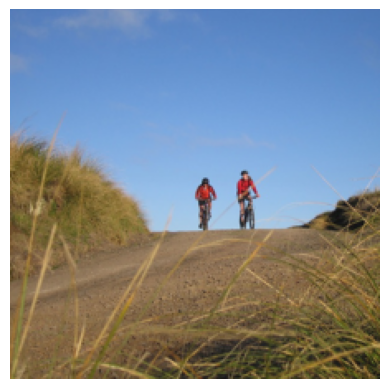

Token_ids: tensor([  2,  15,  26, 213,  95, 474,  39,   4, 106, 159,   5,   3])
Caption :
['<sos>', 'two', 'people', 'ride', 'their', 'bikes', 'down', 'a', 'dirt', 'road', '.', '<eos>']


In [ ]:
img, ids = flickr_dataset[10]
flickr_dataset.display_image(img)
print('Token_ids:', ids)
print('Caption :')
print([flickr_dataset.vocab.get_itos()[token] for token in ids.tolist()])

********  350529848_9569a3bcbc.jpg


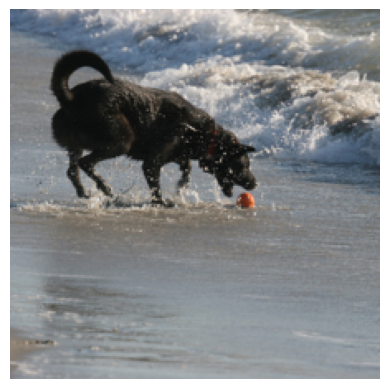

Token_ids: tensor([  2,  11, 426,  42,   6,  27,   5,   3])
Caption :
['<sos>', 'dog', 'chases', 'ball', 'in', 'water', '.', '<eos>']


In [ ]:
img, ids = flickr_dataset[777]
flickr_dataset.display_image(img)
print('Token_ids:', ids)
print('Caption :')
print([flickr_dataset.vocab.get_itos()[token] for token in ids.tolist()])

In [ ]:
# Seems like not all captions are entirely accurate.
captions.loc[captions['image'] == '350529848_9569a3bcbc.jpg']

,image,caption
29925,350529848_9569a3bcbc.jpg,Dog chases ball in water .
29926,350529848_9569a3bcbc.jpg,"Two black dogs playing in surf , one grabbing ..."
29927,350529848_9569a3bcbc.jpg,two black dogs race for a ball on the shore .
29928,350529848_9569a3bcbc.jpg,Two dogs playing on a beach with a red ball wh...
29929,350529848_9569a3bcbc.jpg,Two dogs play in the surf and one has a red ba...


In [ ]:
batch_size = 64

pad_idx = vocab['<pad>']

data_loader = DataLoader(
    dataset =  flickr_dataset,
    batch_size = batch_size,
    shuffle = True,
    collate_fn = GenerateBatchCaptions(pad_idx = pad_idx, batch_first = True)
)
